# Apartments.com NLP 

Hello, Audrey here. In this notebook, I'm scraping 500 listings from www.apartments.com for four neighborhoods: East Hollywood, Boyle Heights, Koreatown, and Highland Park. Each listing includes a description as well as three types of amenities (Unique Amenities, Apartment Features, and Community Amenities). I calculated and created bar graphs of each category’s word frequencies.

Example apartments.com listing: https://www.apartments.com/lido-apartments-los-angeles-ca/9nkznr5/ 

In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
import requests
from bs4 import BeautifulSoup

In [3]:
import time
import random

In [4]:
import re

## getPosts() Function - including lat/lon, unit mix, rents

The following function takes in a neighborhood name and desired number of listings as parameters. The function scrapes the posts up until the page that contains the last listing requested. As there are 25 listings per page on apartments.com, requesting 5 posts will scrape 25, requesting 30 posts will scrape 50, and requesting 501 posts will scrape 525 listings. 

In [5]:
def getPosts(neighborhood, howmany):
    postList = []
    n = neighborhood.replace(' ', '-')
    
    # range 0 (1st page) - number of posts you want, going up in 120 increments 
    ## looping over the pages until you reach the target HOWMANY posts 
    for i in range(0, howmany, 25): 
        print(i)
        
##### FOR EACH PAGE: 
        # insert neighborhood and number of posts to scrape 
        url = f'https://www.apartments.com/{n}-los-angeles-ca/{i}/'  
        
        #request the text from the url 
        time.sleep(random.random()*5)
        r =requests.get(url, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"})
        soup = BeautifulSoup(r.content)

        #get a list of posts 
        posts = soup.find_all('li', class_="mortar-wrapper")
        
        #FOR EACH POST 
        for post in posts: 
            #name
            name = post.find('span', class_="js-placardTitle title")
            if name is not None: 
                name = name.text 
            
            #address
            addy = post.find('div', class_="property-address js-url")
            if addy is not None: 
                addy = addy.text 

            #price 
            price = post.find('div', class_= "price-range")
            if price is not None: 
                price = price.text  
            
            #unit type - each post has a table of unit type and price, do that in another function
            beds = post.find('div', class_="bed-range")   
            if beds is not None:
                beds = beds.text  

##### INDIVIDUAL LISTING 
            #go into the individual post's url 
            url_post = post.find('a', class_="property-link")['href']
            time.sleep(random.random()*7)
            r_post = requests.get(url_post, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"})
            soup_post = BeautifulSoup(r_post.content)
            
            #unit mix, rents 
            BR = soup_post.find_all('div', class_ = "priceBedRangeInfo")
            if BR is not None:
                BR = BR
                unit_type = []
                rents = []
                details = []
                for unit in BR: 
                    unit_type += unit.find_all('span', class_ = 'modelName')
                    rents += unit.find_all('span', class_='rentLabel')
                    details += unit.find_all('span', class_= "detailsTextWrapper")

            
            #description 
            description = soup_post.find('section', id="descriptionSection")  
            

            #unique amenities
            unique_a = soup_post.find_all('li', class_ ="specInfo uniqueAmenity")
            if unique_a is not None:
                unique_a = unique_a 
#            print(type(unique_a)) 

            #community amenities
            comm_a = soup_post.find_all('ul', class_ ="combinedAmenitiesList")
            if comm_a is not None:
                comm_a = comm_a 
#            print(type(comm_a)) 

            #apartment features 
            apt_a = soup_post.find_all('span', class_ ="amenity")
            if apt_a is not None:
                apt_a = apt_a 
#            print(type(apt_a)) 
#            <li class="specInfo">
 
            #latlon
            latlons = soup_post.find_all('script', type="text/javascript")
            for ll in latlons:
                 if 'location:' in ll.string and 'latitude:' in ll.string and 'longitude' in ll.string:
                    # we found the right one. Use regex to get the lat  
                        lat = re.findall("latitude: (\d*\.?\d*)",ll.string)
                        # same for longitude
                        lon = re.findall("longitude: (\-\d*\.?\d*)",ll.string)


            postList.append({'Listing':name, 'Address':addy, 'Latitude': lat, 'Longitude':lon, 'Description':description,'Price': price, 'Unit Type':beds, 'BR': BR, 'unit_type': unit_type, 'rents': rents, 'Unique Amenities':unique_a, 'Apartment Features':apt_a, 'Community Amenities':comm_a, 'URL':url_post})
#                 BR = BR
#                unit_type = []
#                rents = []
            # missing: 'lat': latitude, 'lon': longitude, 'Phone': phone
            
            
        df = pd.DataFrame(postList)
        
        # convert lat/lon into pretty form 
        df['Longitude'] = df['Longitude'].apply(lambda x: x[0])
        df['Latitude'] = df['Latitude'].apply(lambda x: x[0])
        df['Longitude'] = pd.to_numeric(df['Longitude'])
        df['Latitude'] = pd.to_numeric(df['Latitude'])
        
        # add geometry column 
        # df["geometry"] = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")
        
    return gdf

Q: The lat/lon values for each listing was a string in a single-element list. I cleaned this outside of the dataframe, but I want to figure out a more elegant way to do this within the getPosts() function itself, if possible. I feel like this could be done with lambda?

A: If it’s a single element string, then yes - use lambda, where you just get the first element of the list. df[‘Longitude’] = df[‘Longitude’].apply(lambda x: x[0])
Basically, each row of Longitude appears in your lambda function as the variable x, and then you return the first element of x, i.e. x[0]

## Scrape 500 posts 

Run getPosts() function to scrape 500 posts for each neighborhood.

In [9]:
eho_500 = getPosts('East Hollywood', 500) 

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475


In [12]:
bohe_500 = getPosts('Boyle Heights', 500)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475


In [6]:
ktown_500 = getPosts('Koreatown', 500)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475


In [7]:
hipa_500 = getPosts('Highland Park', 500)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475


Testing... the following should be a list... 

In [20]:
eho_500['Unique Amenities'][0]

[<li class="specInfo uniqueAmenity">
 <span>Barbecues</span>
 </li>,
 <li class="specInfo uniqueAmenity">
 <span>Built In Barbecue Bars</span>
 </li>,
 <li class="specInfo uniqueAmenity">
 <span>Chaise Lounges For Sun Bathing</span>
 </li>,
 <li class="specInfo uniqueAmenity">
 <span>Custom Cabinetry W/ Self Closing Doors</span>
 </li>,
 <li class="specInfo uniqueAmenity">
 <span>Designer Kitchen</span>
 </li>,
 <li class="specInfo uniqueAmenity">
 <span>Designer Kitchens</span>
 </li>,
 <li class="specInfo uniqueAmenity">
 <span>Designer Kitchens With Custom Cabinetry</span>
 </li>,
 <li class="specInfo uniqueAmenity">
 <span>Electric Ovens</span>
 </li>,
 <li class="specInfo uniqueAmenity">
 <span>Entertainment Lounge With Outdoor T.v.</span>
 </li>,
 <li class="specInfo uniqueAmenity">
 <span>Fire-Pits</span>
 </li>,
 <li class="specInfo uniqueAmenity">
 <span>Foosball Table</span>
 </li>,
 <li class="specInfo uniqueAmenity">
 <span>Game Room</span>
 </li>,
 <li class="specInfo uniq

In [21]:
# saving the gdfs of 500 scraped posts for each neighborhood to csvs so I don't have to scrape again: 
eho_500.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/Final229_csvs/eho_500_gdf.csv')
bohe_500.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/Final229_csvs/bohe_500_gdf.csv')
ktown_500.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/Final229_csvs/ktown_500_gdf.csv')
hipa_500.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/Final229_csvs/hipa_500_gdf.csv')

## Note that these gdfs have not gotten their amenities columns cleaned for analysis. 

ktown_500.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/Final229_csvs/ktown_500_gdf.csv')
hipa_500.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/Final229_csvs/hipa_500_gdf.csv')

## Mapping 500 scraped posts

I will now map the posts scraped for each neighborhood.

In [28]:
import matplotlib.pyplot as plt
import contextily as ctx

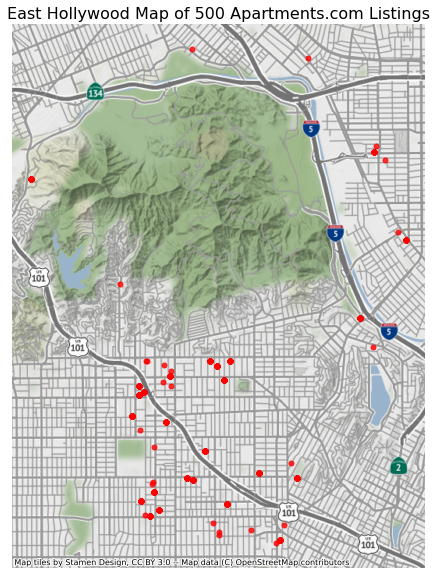

In [91]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(10, 10))

# add the layer with ax=ax in the argument 
eho_500.to_crs('EPSG:3857').plot(ax=ax, alpha=0.8, markersize=25, color = "red")

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('East Hollywood Map of 500 Apartments.com Listings',fontsize=16)

# add a basemap
ctx.add_basemap(ax)

### Dropping listings outside neighborhood boundaries

It looks like there's listings in this dataframe that are outside of East Hollywood, on the other side of the I-5 freeway and north of Griffith Park, even. 

I want to drop listings that don't intersect with the appropriate neighborhood. I am using [this API](https://geohub.lacity.org/datasets/d6c55385a0e749519f238b77135eafac_0?geometry=-118.335%2C34.078%2C-118.252%2C34.103) of LA Times Neighborhood Boundaries. 

In [30]:
r_api = requests.get('https://opendata.arcgis.com/datasets/d6c55385a0e749519f238b77135eafac_0.geojson')
import json 
d_api = json.loads(r_api.text)

In [40]:
print(d_api.keys())
print(d_api['features']) #looks like the features key holds the neighborhood polygons

dict_keys(['type', 'name', 'crs', 'features'])
[{'type': 'Feature', 'properties': {'OBJECTID': 1, 'name': 'Adams-Normandie'}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-118.30068619528, 34.0373138507143], [-118.303884196041, 34.037204851199], [-118.300287171334, 34.0372359462978], [-118.297604625712, 34.0372591365581], [-118.296712194924, 34.0372668512001], [-118.296295194457, 34.0372348512573], [-118.29636119452, 34.036894851016], [-118.291561193707, 34.0368418515945], [-118.291550192661, 34.0255018502656], [-118.291552596393, 34.0255018543774], [-118.308899196446, 34.025557849759], [-118.309000196885, 34.0374328504795], [-118.30801419718, 34.0374008510931], [-118.30068619528, 34.0373138507143]]]}}, {'type': 'Feature', 'properties': {'OBJECTID': 2, 'name': 'Arleta'}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-118.442545891184, 34.2641222795749], [-118.44240123835, 34.2639378683128], [-118.442192237944, 34.2639908679317], [-118.441338237303, 34.2626268676857], [-118.441

In [66]:
gdf_api = gpd.GeoDataFrame.from_features(d_api['features'])
gdf_api.crs = "EPSG:4326"
# loading json into a geodataframe 
## SOURCE: https://stackoverflow.com/questions/45552955/loading-json-into-a-geodataframe

geometry  OBJECTID  \
0    POLYGON ((-118.30069 34.03731, -118.30388 34.0...         1   
1    POLYGON ((-118.44255 34.26412, -118.44240 34.2...         2   
2    POLYGON ((-118.31862 34.05306, -118.31673 34.0...         3   
3    MULTIPOLYGON (((-118.27886 34.15321, -118.2788...         4   
4    POLYGON ((-118.36102 34.02532, -118.36026 34.0...         5   
..                                                 ...       ...   
109  MULTIPOLYGON (((-118.28331 33.75532, -118.2880...       110   
110  POLYGON ((-118.31404 34.06254, -118.31420 34.0...       111   
111  POLYGON ((-118.56232 34.23199, -118.56232 34.2...       112   
112  POLYGON ((-118.57240 34.18668, -118.57161 34.1...       113   
113  POLYGON ((-118.50116 34.22114, -118.50116 34.2...       114   

                       name  
0           Adams-Normandie  
1                    Arleta  
2         Arlington Heights  
3           Atwater Village  
4    Baldwin Hills/Crenshaw  
..                      ...  
109              Wilmington  
110          Windsor Square  
111                Winnetka  
112          Woodland Hills  
113             Lake Balboa  

[114 rows x 3 columns]

**East Hollywood** 

In [74]:
easthollywood = gdf_api[gdf_api['name'] == 'East Hollywood']

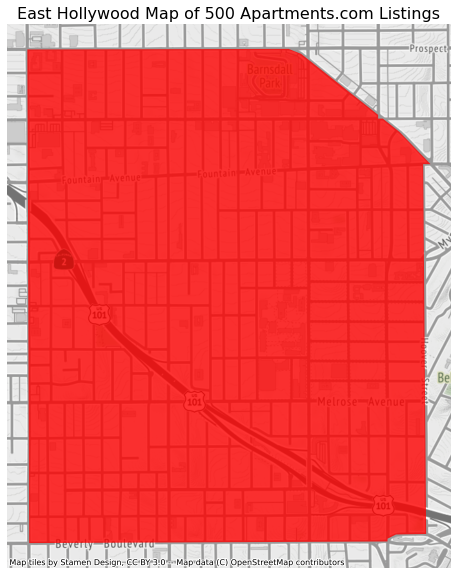

In [89]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(10, 10))

# add the layer with ax=ax in the argument 
easthollywood.to_crs('EPSG:3857').plot(ax=ax, alpha=0.8, markersize=25, color = "red")

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('East Hollywood Map of 500 Apartments.com Listings',fontsize=16)

# add a basemap
ctx.add_basemap(ax)

In [87]:
eho_500_ = gpd.sjoin(eho_500, easthollywood, how = 'inner', op = 'intersects')
print(len(eho_500))
print(len(eho_500_)) 

500
114


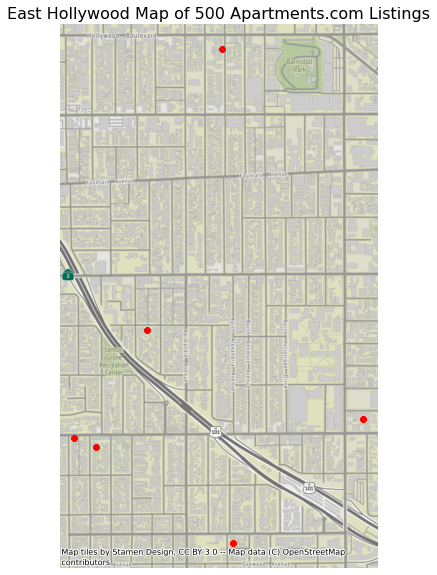

In [90]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(10, 10))

# add the layer with ax=ax in the argument 
eho_500_.to_crs('EPSG:3857').plot(ax=ax, alpha=0.8, markersize=25, color = "red")

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('East Hollywood Map of 500 Apartments.com Listings',fontsize=16)

# add a basemap
ctx.add_basemap(ax)

There's only a 114 listings that are actually within the East Hollywood official boundaries. But I want to include the cluster that may be a bit beyond but still generally in that area. So I'm adding a 1000m buffer to the neighborhood polygon:

In [109]:
easthollywood_ = easthollywood.to_crs("EPSG:3857").geometry.buffer(1000)

#SOURCE: https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.GeoSeries.buffer.html 

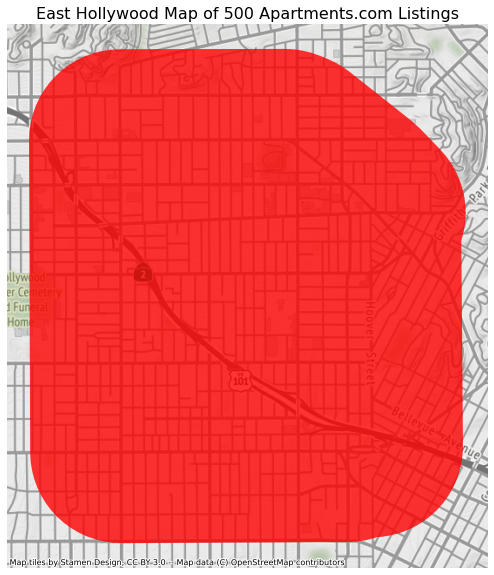

In [110]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(10, 10))

# add the layer with ax=ax in the argument 
easthollywood_.to_crs('EPSG:3857').plot(ax=ax, alpha=0.8, markersize=25, color = "red")

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('East Hollywood Map of 500 Apartments.com Listings',fontsize=16)

# add a basemap
ctx.add_basemap(ax)

In [125]:
easthollywood_gpd = gpd.GeoDataFrame(geometry=easthollywood_.to_crs("EPSG:4326"))
#easthollywood_gpd.set_crs("EPSG:4326")

In [126]:
#double _ _ indicates listings that fall within 1000m of official neighborhood boundary 
eho_500__ = gpd.sjoin(eho_500, easthollywood_gpd, how = 'inner', op = 'intersects')
print(len(eho_500))
print(len(eho_500__)) 

500
398


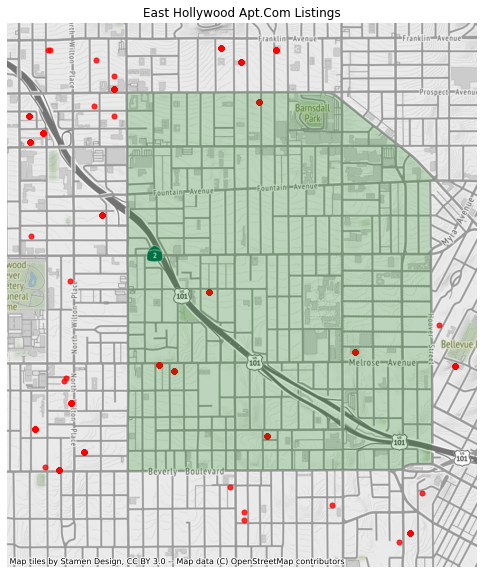

In [136]:
fig, ax = plt.subplots(figsize=(10, 10))
 
# add listings layer 
eho_500__.to_crs('EPSG:3857').plot(ax=ax, alpha=0.8, markersize=25, color = "red")

# add neighborhood polygon layer 
easthollywood.to_crs('EPSG:3857').plot(ax=ax, alpha=0.2, color = "green")

ax.axis("off")
ax.set_title("East Hollywood Apt.Com Listings")

# add a basemap
ctx.add_basemap(ax)

Dropped about a hundred listings that were not within 1000m of the official East Hollywood neighborhood boundaries. It seems that landlords pretty far north of East Hollywood claim the neighborhood in their listings. 

**Boyle Heights**

In [131]:
boyleheights = gdf_api[gdf_api['name'] == 'Boyle Heights']
boyleheights_ = boyleheights.to_crs("EPSG:3857").geometry.buffer(1000)
boyleheights_gpd = gpd.GeoDataFrame(geometry=boyleheights_.to_crs("EPSG:4326"))

bohe_500_ = gpd.sjoin(bohe_500, boyleheights_gpd, how = 'inner', op = 'intersects')
print(len(bohe_500))
print(len(bohe_500_)) 

497
497


Didn't need to drop any posts I guess! Let's map the listings on the neighborhood boundaries: 

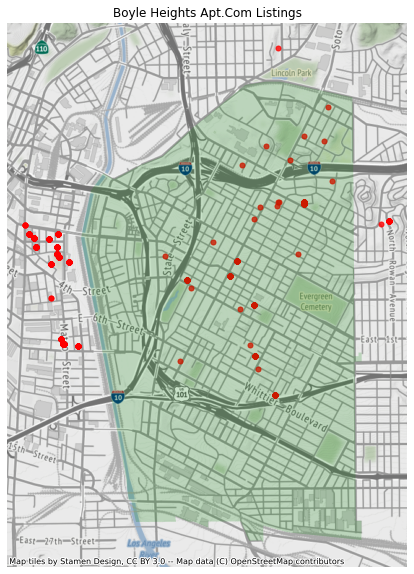

In [135]:
fig, ax = plt.subplots(figsize=(10, 10))
 
# add listings layer 
bohe_500_.to_crs('EPSG:3857').plot(ax=ax, alpha=0.8, markersize=25, color = "red")

# add neighborhood polygon layer 
boyleheights.to_crs('EPSG:3857').plot(ax=ax, alpha=0.2, color = "green")

ax.axis("off")
ax.set_title("Boyle Heights Apt.Com Listings")

# add a basemap
ctx.add_basemap(ax)

All listings marketed as Boyle Heights are within 1000m of official Boyle Heights boundaries. 

**Koreatown**

In [137]:
koreatown = gdf_api[gdf_api['name'] == 'Koreatown']
koreatown_ = koreatown.to_crs("EPSG:3857").geometry.buffer(1000)
koreatown_gpd = gpd.GeoDataFrame(geometry=koreatown_.to_crs("EPSG:4326"))

ktown_500_ = gpd.sjoin(ktown_500, koreatown_gpd, how = 'inner', op = 'intersects')
print(len(ktown_500))
print(len(ktown_500_)) 

500
488


Dropped 12 listings that were beyond 1000m from Koreatown official boundaries. 

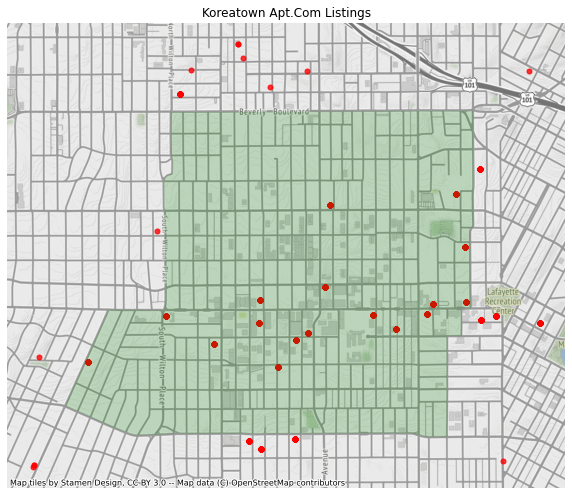

In [139]:
fig, ax = plt.subplots(figsize=(10, 10))
 
# add listings layer 
ktown_500_.to_crs('EPSG:3857').plot(ax=ax, alpha=0.8, markersize=25, color = "red")

# add neighborhood polygon layer 
koreatown.to_crs('EPSG:3857').plot(ax=ax, alpha=0.2, color = "green")

ax.axis("off")
ax.set_title("Koreatown Apt.Com Listings")

# add a basemap
ctx.add_basemap(ax)

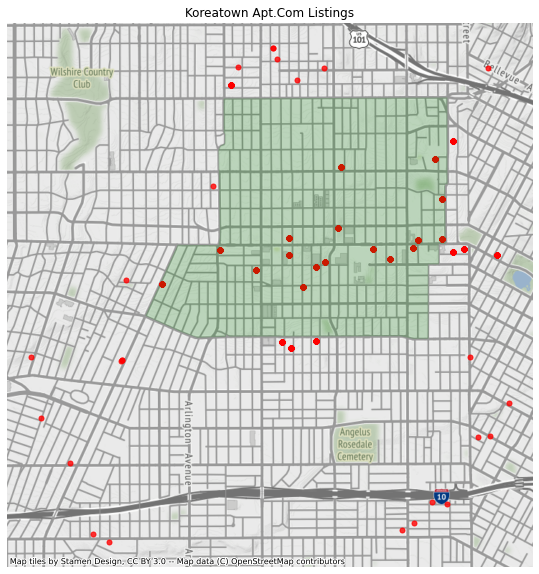

In [140]:
fig, ax = plt.subplots(figsize=(10, 10))
 
# add listings layer 
ktown_500.to_crs('EPSG:3857').plot(ax=ax, alpha=0.8, markersize=25, color = "red")

# add neighborhood polygon layer 
koreatown.to_crs('EPSG:3857').plot(ax=ax, alpha=0.2, color = "green")

ax.axis("off")
ax.set_title("Koreatown Apt.Com Listings")

# add a basemap
ctx.add_basemap(ax)

Landlords south of Koreatown boundaries claim the neighborhood in their listings, even on the other side of the 10 Freeway, where there is much less development and investment. 

**Highland Park**

In [143]:
highlandpark = gdf_api[gdf_api['name'] == 'Highland Park']
highlandpark_ = highlandpark.to_crs("EPSG:3857").geometry.buffer(1000)
highlandpark_gpd = gpd.GeoDataFrame(geometry=highlandpark_.to_crs("EPSG:4326"))

hipa_500_ = gpd.sjoin(hipa_500, highlandpark_gpd, how = 'inner', op = 'intersects')
print(len(hipa_500))
print(len(hipa_500_)) 

500
462


Had to drop 38 listings that were beyond 1000m from Highland Park! 

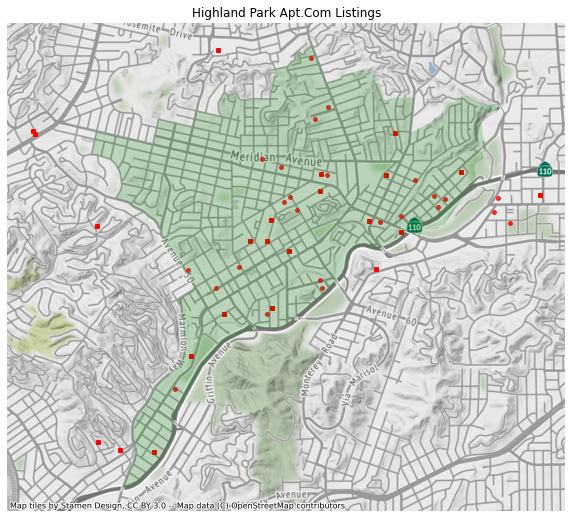

In [190]:
fig, ax = plt.subplots(figsize=(10, 10))
 
# add listings layer 
hipa_500_.to_crs('EPSG:3857').plot(ax=ax, alpha=0.8, markersize=15, color = "red")

# add neighborhood polygon layer 
highlandpark.to_crs('EPSG:3857').plot(ax=ax, alpha=0.2, color = "green")

ax.axis("off")
ax.set_title("Highland Park Apt.Com Listings")

# add a basemap
ctx.add_basemap(ax)

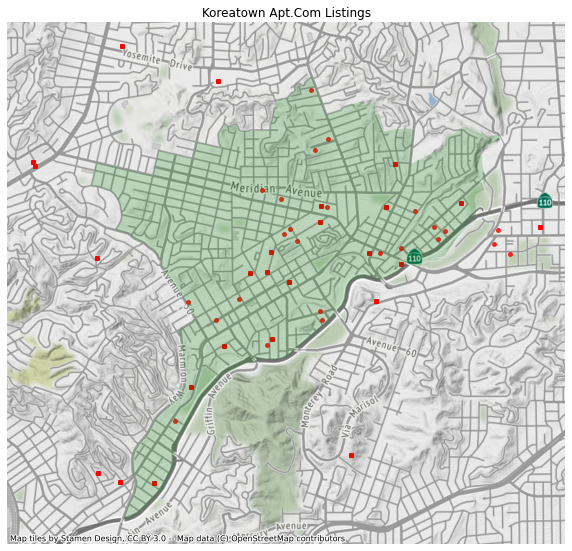

In [146]:
fig, ax = plt.subplots(figsize=(10, 10))
 
# add listings layer 
hipa_500.to_crs('EPSG:3857').plot(ax=ax, alpha=0.8, markersize=15, color = "red")

# add neighborhood polygon layer 
highlandpark.to_crs('EPSG:3857').plot(ax=ax, alpha=0.2, color = "green")

ax.axis("off")
ax.set_title("Koreatown Apt.Com Listings")

# add a basemap
ctx.add_basemap(ax)

Not sure why the maps look so similar if 38 listings were dropped? Listings marked as Highland Park were probably all pretty close to the official boundaries, within or a little further than 1000m. 

## Description NLP  

I run NLPs on description wordlists drawn from all 500 listings as well as the wordlists that exclude listings beyond 1000m of a neighborhood boundary. I supposed that if something caused apartments.com to return a particular listing in a neighborhood search, it's worth analyzing its marketing narrative with the other listings under that neighborhood. 

As you will see, when I compared the word frequencies for keeping all 500 listings versus dropping those beyond 1000m of official neighborhood boundaries, I didn't see much of a difference in meaningful keywords. 

In [151]:
##### DO NOT RUN ####
## As a backup, I saved the string of 500 scraped posts for each neighborhood into a dataframe
# descriptions = pd.DataFrame([str_eho500, str_bohe500, str_ktown500, str_hipa500])
# descriptions.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/Final229_csvs/descriptions_str.csv')

# descriptions_wl = pd.DataFrame([wl500_eho, wl500_bohe, wl500_ktown, wl500_hipa])
# descriptions_wl.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/Final229_csvs/descriptions_wl.csv')

In [148]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\audre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\audre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 1. Create a long string of the Descriptions of each listing scraped, then split into a wordlist 
Removing tags, lines, white spaces, tabs, punctuation with regex library

In [191]:
# edited the stringify_np function to turn a dataframe of posts into a long string with no punctuations, then splits into wordlists 

def return_wordlist(postdf, column):
    
    series = postdf[column].apply(str)
    list_ = series.tolist()
    string = str(list_)
    
    #remove tags 
    notags = re.sub(r"<[^>]*>", "", string)

    #remove new lines 
    nnline = re.sub(r"\\n", " ", notags)
    
    #remove white spaces and tabs (\t)
    words = re.sub(r"\s+", " ", nnline)
    
    #remove punctuation 
    words_np = re.sub(r"[^A-z\s]", "", words)
    
    # wordlistify 
    wordlist = words_np.split()
    
    return wordlist
    

In [214]:
# split the string of descriptions of each neighborhood's first 500 apt.com posts into a list of single words  
wl500_eho = return_wordlist(eho_500, "Description")
wl500_bohe = return_wordlist(bohe_500, "Description")
wl500_ktown = return_wordlist(ktown_500, "Description")
wl500_hipa = return_wordlist(hipa_500, "Description")

In [211]:
# split the string of descriptions of apt.com posts within 1000m of a neighborhood into a list of single words  
wl500_eho_ = return_wordlist(eho_500_, "Description")
wl500_bohe_ = return_wordlist(bohe_500_, "Description")
wl500_ktown_ = return_wordlist(ktown_500_, "Description")
wl500_hipa_ = return_wordlist(hipa_500_, "Description")

Now we're ready to find the word frequencies. 

### 2. Wordcounter - excluding stopwords 

From the raw word frequencies, I picked out the uninteresting words to add to the stopwords list within this second word counting function.

In [154]:
def countWords_nostop(wordlist): 
    # original code: swords = [re.sub(r"[^A-z\s]", "", sword) for sword in stopwords.words('english')]
    swords = stopwords.words('english')
    swords.extend(('br', 'div', 'la', 'los', 'angeles', 'apartments', 'housing', 'apartment', 'month', 'lease', 'one', 'bedroom', 'homes', 'select', 'including', 'available', 'deposit','st','ca', 'amp', 'e', 'located', 'nd', 'ave'))
    ###add more stopwords to remove here^ 
    
    counts = {} # a dictionary to hold the counts
    for word in wordlist:
        # make lower case 
        lword = word.lower()
        
        # skip the stop words
        if lword in swords:
            continue
        
        # add to list of counts  
        elif lword in counts:
            counts[lword] +=1
        else:
            # doesn't exist in the dictionary
            counts[lword] = 1

    # convert the dictionary to a dataframe SOURCE: https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe
    df = pd.DataFrame.from_dict(counts, orient='index', columns=['word_count'])

    # sort it by the word_count column
    df.sort_values('word_count', ascending=False, inplace=True)
    df.index.name = 'word'

    return df


**East Hollywood** - Descriptions Word Count

In [217]:
print("Top 10 Most Frequently Used Words from East Hollywood's first 500 Apt.com Listing Descriptions")
eho_freq = countWords_nostop(wl500_eho)
eho_freq.head(10)

Top 10 Most Frequently Used Words from East Hollywood's first 500 Apt.com Listing Descriptions


word_count
word                  
community          799
hollywood          581
free               577
features           565
shared             515
private            514
parking            457
home               421
appliances         387
furnished          380

Okay let's see if excluding the listings further than 1000m from official neighborhood boundaries does anything:

In [216]:
print("Top 10 Most Frequently Used Words from 398 East Hollywood Apt.com Listing Descriptions")
eho_freq_ = countWords_nostop(wl500_eho_)
eho_freq_.head(10)

Top 10 Most Frequently Used Words from 398 East Hollywood Apt.com Listing Descriptions


word_count
word                 
room              152
unit              152
community         133
rent              133
living            133
free              133
units             133
home              133
private           133
park              114

If we ignore the less meaningful words like "room", "unit" "rent", "living", the description NLP is similar regardless of whether I include or exclude the listings beyond 1000m. 

In [ ]:
import matplotlib.pyplot as plt  

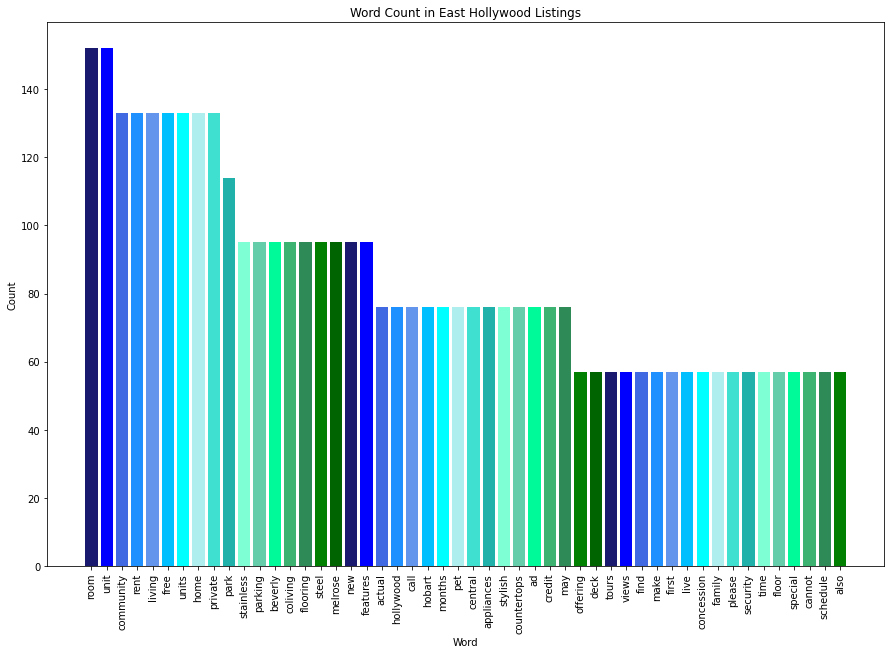

In [270]:
eho_freq_ = eho_freq_.reset_index()

#bar chart
plt.figure(figsize=(15,10))
plt.bar(eho_freq_.head(50)['word'], eho_freq_.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Word Count in East Hollywood Listings")
plt.show()
#text = mylines_words


"Community", "free", and "private" are notably among the highest frequency words. 

**Boyle Heights** - Descriptions Word Count

In [218]:
print("Top 10 Most Frequently Used Words from Boyle Heights' first 500 Apt.com Listing Descriptions")
bohe_freq = countWords_nostop(wl500_bohe)
bohe_freq.head(10)

Top 10 Most Frequently Used Words from Boyle Heights' first 500 Apt.com Listing Descriptions


word_count
word                  
unit               475
district           403
kitchen            388
arts               384
downtown           367
lofts              321
home               316
living             313
parking            300
appliances         289

There weren't any listings beyond 1000m of Boyle Heights boundaries to drop. Place names such as **"arts district"** and **"downtown"**, and amenities such as  **"lofts"**, **"parking"**, and **"appliances"** seem to be key sellers for Boyle Heights.

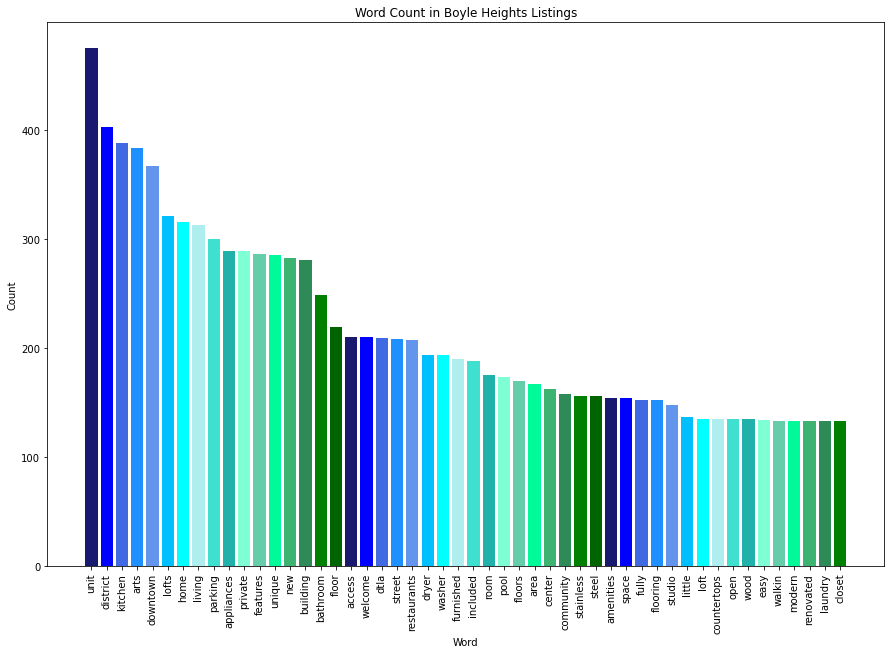

In [271]:
bohe_freq = bohe_freq.reset_index()

#bar chart
plt.figure(figsize=(15,10))
plt.bar(bohe_freq.head(50)['word'], bohe_freq.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Word Count in Boyle Heights Listings")
plt.show()
#text = mylines_words

**Koreatown**

In [225]:
print("Top 10 Most Frequently Used Words from Koreatown's first 500 Apt.com Listing Descriptions")
ktown_freq = countWords_nostop(wl500_ktown)
ktown_freq.head(20)

Top 10 Most Frequently Used Words from Koreatown's first 500 Apt.com Listing Descriptions


word_count
word                  
koreatown          590
unique             532
features           500
custom             495
room               465
flooring           443
community          438
pool               437
designer           420
lounge             418
rooftop            401
appliances         391
floor              389
units              386
views              383
deck               382
fitness            381
wilshire           380
private            366
center             364

**"unique features"** is right -- Koreatown listings have high frequencies of amenity keywords such as **"custom"**, **"pool"**, **"designer"**, and **"lounge"**. 

The top ten words for ktown listings excluding extraneous posts are exactly the same. 

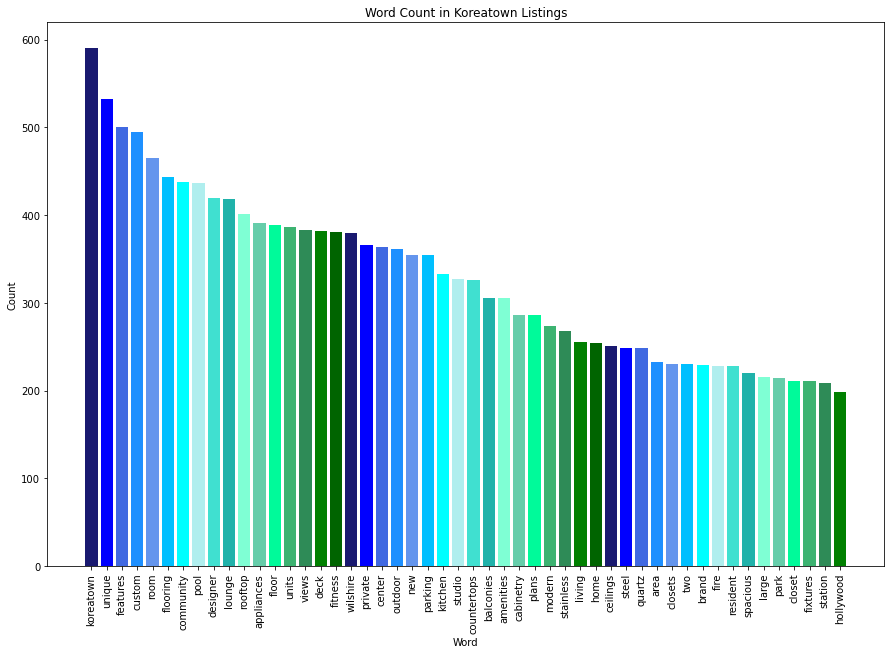

In [272]:
ktown_freq = ktown_freq.reset_index()

#bar chart
plt.figure(figsize=(15,10))
plt.bar(ktown_freq.head(50)['word'], ktown_freq.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Word Count in Koreatown Listings")
plt.show()
#text = mylines_words


**Highland Park**

In [159]:
print("Top 50 Most Frequently Used Words from Highland Park's first 500 Apt.com Listing Descriptions")
hipa_freq = countWords_nostop(wl500_hipa)
hipa_freq.head(10)

Top 50 Most Frequently Used Words from Highland Park's first 500 Apt.com Listing Descriptions


word_count
word                
park             727
new              704
highland         518
unit             456
parking          418
pasadena         353
features         345
home             313
units            285
kitchen          285

For Highland Park, **"new"** and **"parking"** are the top keywords, as well as nearby **"pasadena"**.  Again, excluding extraneous listings didn't do much. 

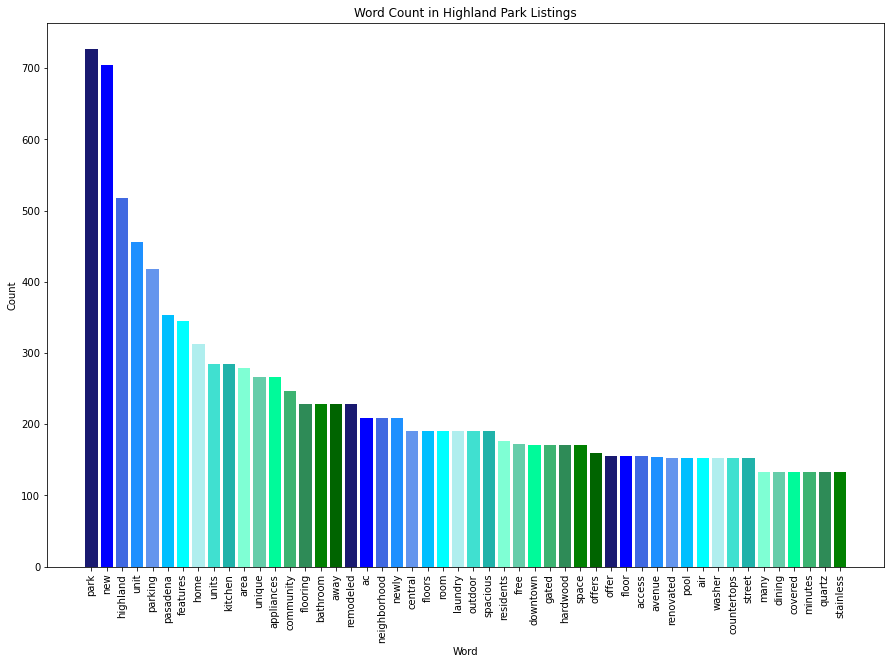

In [273]:
hipa_freq = hipa_freq.reset_index()

#bar chart
plt.figure(figsize=(15,10))
plt.bar(hipa_freq.head(50)['word'], hipa_freq.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Word Count in Highland Park Listings")
plt.show()
#text = mylines_words

The top frequency keyword for East Hollywood is **"community"**, for Boyle Heights **"arts district"**, for Koreatown **"unique"**, and for Highland Park it's **"new"**. 

**"parking"** was pretty high up on the list for East Hollywood and Highland Park, a bit further down for Koreatown, and didn't make the top 50 for Boyle Heights. 

Also interesting was how frequently nearby neighborhoods like **"downtown"**, **"pasadena"**, **"figueroa"** and **"larchmont"** appeared in the listing descriptions. 

## Amenities NLP 

Apartments.com provides three categories of amenities. "Unique Amenities" seem to be filled in freeform by the listing agent, while "Apartment Features" annd "Community Amenities" are more standardized.

I dropped the listings further than 1000m for this exercise, because amenities more directly affect the developer/landlord's bottom line, and thus are likely more dependent on actual location of competitive projects. 

In [187]:
#### DO NOT RUN ####
## save wordlists into dataframes 
# amenities = pd.DataFrame({'Unique Amenities':[ua_eho, ua_bohe, ua_ktown, ua_hipa], 
#                              'Apartment Features': [af_eho, af_bohe, af_ktown, af_hipa],
#                              'Community Amenities': [ca_eho, ca_bohe, ca_ktown, ca_hipa]})
# amenities = eho_amenities.rename(index={0: "eho", 1: "bohe", 2:"ktown", 3:"hipa"})

# amenities.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/Final229_csvs/amenities.csv')


### Create wordlists for each amenity type

In [234]:
##unique amenities
wlua_eho = return_wordlist(eho_500, "Unique Amenities")
wlua_bohe =return_wordlist(bohe_500, "Unique Amenities")
wlua_ktown = return_wordlist(ktown_500, "Unique Amenities")
wlua_hipa = return_wordlist(hipa_500, "Unique Amenities")

##apartment features
wlaf_eho = return_wordlist((eho_500), "Apartment Features")
wlaf_bohe = return_wordlist((bohe_500), "Apartment Features")
wlaf_ktown = return_wordlist((ktown_500), "Apartment Features")
wlaf_hipa = return_wordlist((hipa_500), "Apartment Features")


##community amenities 
wlca_eho = return_wordlist((eho_500), "Community Amenities")
wlca_bohe = return_wordlist((bohe_500), "Community Amenities")
wlca_ktown = return_wordlist((ktown_500), "Community Amenities")
wlca_hipa = return_wordlist((hipa_500), "Community Amenities")

In [235]:
##unique amenities
wlua_eho_ = return_wordlist(eho_500_, "Unique Amenities")
wlua_bohe_ =return_wordlist(bohe_500_, "Unique Amenities")
wlua_ktown_ = return_wordlist(ktown_500_, "Unique Amenities")
wlua_hipa_ = return_wordlist(hipa_500_, "Unique Amenities")

##apartment features
wlaf_eho_ = return_wordlist((eho_500_), "Apartment Features")
wlaf_bohe_ = return_wordlist((bohe_500_), "Apartment Features")
wlaf_ktown_ = return_wordlist((ktown_500_), "Apartment Features")
wlaf_hipa_ = return_wordlist((hipa_500_), "Apartment Features")


##community amenities 
wlca_eho_ = return_wordlist((eho_500_), "Community Amenities")
wlca_bohe_ = return_wordlist((bohe_500_), "Community Amenities")
wlca_ktown_ = return_wordlist((ktown_500_), "Community Amenities")
wlca_hipa_ = return_wordlist((hipa_500_), "Community Amenities")

### Unique Amenities

Finally, we're ready to run a word count on the amenities.

#### East Hollywood - Unique Amenities 

In [241]:
print("Unique Amenities Frequencies - East Hollywood")
eho_uniqueamenities = countWords_nostop(wlua_eho)
eho_uniqueamenities.head(20)

Unique Amenities Frequencies - East Hollywood


word_count
word                  
[                  341
]                  340
room               209
flooring           190
cabinetry          171
[]                 158
storage            152
parking            152
access             152
outdoor            133
fitness            133
large              133
designer           133
modern             114
fixtures            95
appliances          95
electronic          95
ceilings            95
lighting            95
onsite              95

In [243]:
print("Unique Amenities Frequencies - East Hollywood")
eho_uniqueamenities_ = countWords_nostop(wlua_eho_)
eho_uniqueamenities_.head(20) 

Unique Amenities Frequencies - East Hollywood


word_count
word                   
room                 95
[]                   75
fitness              57
[                    38
fridge               38
paw                  38
pet                  38
friendly             38
]                    37
cabinetry            19
folding              19
bicycles             19
included             19
light                19
fixtures             19
modern               19
work                 19
new                  19
countertops          19
onsite               19

Here there seems to be some difference between dropping non-East Hollywood listings and keeping them in; we'll keep the . 

For the true East Hollywood listings, **"fitness"** and **"pet friendly"** as well as kitchen items such as **"fridge"** and **"cabinetry"** seem to be most popular. 

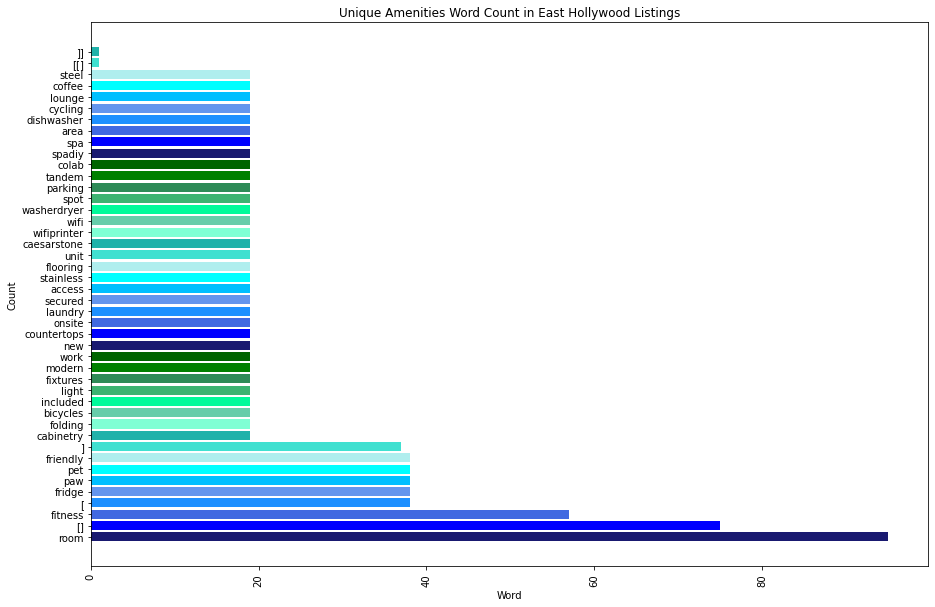

In [274]:
eho_uniqueamenities_ = eho_uniqueamenities_.reset_index()
#bar chart

plt.figure(figsize=(15,10))
plt.barh(eho_uniqueamenities_['word'], eho_uniqueamenities_['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Unique Amenities Word Count in East Hollywood Listings")
plt.show()
#text = mylines_words


#### Boyle Heights - Unique Amenities

In [277]:
print("Unique Amenities Frequencies - Boyle Heights")
bohe_uniqueamenities_ = countWords_nostop(wlua_bohe_)
bohe_uniqueamenities_.head(20)

Unique Amenities Frequencies - Boyle Heights


word_count
word                  
[]                 325
]                  171
[                  170
access              76
charging            76
flooring            76
style               57
throughout          57
gallery             57
options             57
stainless           57
steel               57
appliances          57
private             57
virtual             38
electric            38
vehicle             38
woodstyle           38
program             38
european            38

Some kind of fancy **"flooring"** and **"gallery"** were highest frequency in Boyle Heights.

In [ ]:
bohe_uniqueamenities_ = bohe_uniqueamenities_.reset_index()
#bar chart

plt.figure(figsize=(15,10))
plt.barh(bohe_uniqueamenities_['word'], bohe_uniqueamenities_['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Unique Amenities Word Count in Boyle Heights Listings")
plt.show()
#text = mylines_words


#### Koreatown - Unique Amenities

In [284]:
print("Unique Amenities Frequencies - Koreatown")
ktown_uniqueamenities_ = countWords_nostop(wlua_ktown_)
ktown_uniqueamenities_.head(25)

Unique Amenities Frequencies - Koreatown


word_count
word                   
]                   474
[                   474
custom              342
flooring            285
room                285
countertops         247
designer            247
deck                228
kitchen             228
floor               209
lounge              209
views               209
quartz              209
private             209
parking             209
fitness             209
balconies           190
rooftop             190
fire                190
closet              190
outdoor             190
cabinetry           171
appliances          171
center              171
pool                171

When I first ran this wordcount, the highest frequency unique amenities were **"rooftop"**, **"barbecues"**, and **"spa"**. As a Ktown resident that seemed to hit the mark.

Now, the wordcount has completely changed?? **"custom"**, **"flooring"**, some fancy **"countertops"**, **"deck"** and **"designer"** are top unique amenities in Koreatown.

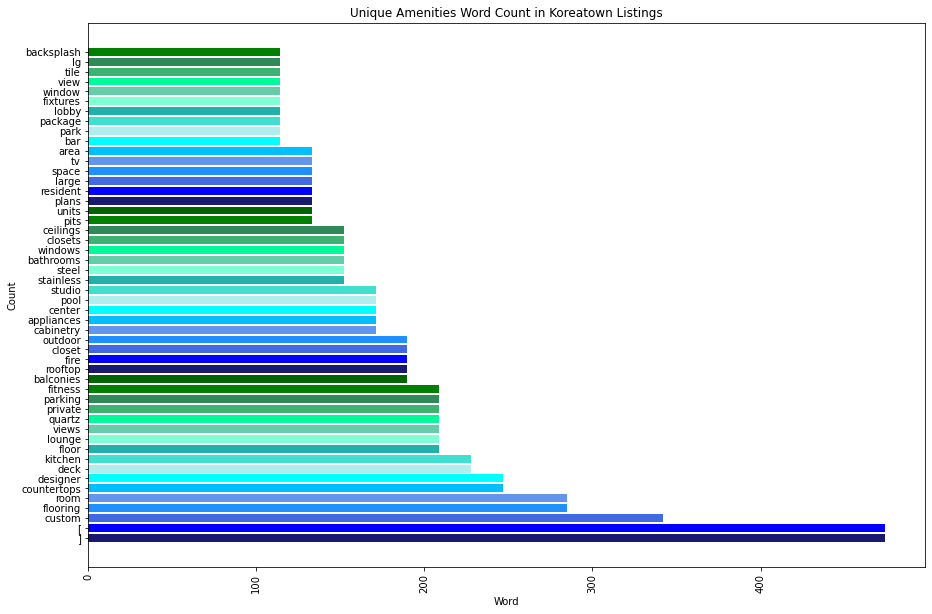

In [282]:
ktown_uniqueamenities_ = ktown_uniqueamenities_.reset_index()
#bar chart

plt.figure(figsize=(15,10))
plt.barh(ktown_uniqueamenities_.head(50)['word'], ktown_uniqueamenities_.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Unique Amenities Word Count in Koreatown Listings")
plt.show()
#text = mylines_words


#### Highland Park - Unique Amenities

In [286]:
print("Unique Amenities Frequencies - Highland Park")
hipa_uniqueamenities_ = countWords_nostop(wlua_hipa_)
hipa_uniqueamenities_.head(20)

Unique Amenities Frequencies - Highland Park


word_count
word                   
[]                  270
[                   190
]                   190
parking              95
appliances           76
central              76
area                 57
open                 57
outdoor              57
flooring             57
quartz               57
countertops          57
efficient            57
floors               57
air                  57
move                 57
heat                 38
bbq                  38
week                 38
remodeled            38

Last time I did this, Highland Park listings had high frequency of **"amazon hubs"** and **"appliances"**. Now, the highest unique amenities are **"parking"** and **"appliances"**. **"central"** could be referring to "central air" or "central" geographic location. 

In [ ]:
ktown_uniqueamenities_ = ktown_uniqueamenities_.reset_index()
#bar chart

plt.figure(figsize=(15,10))
plt.barh(ktown_uniqueamenities_.head(50)['word'], ktown_uniqueamenities_.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Unique Amenities Word Count in Koreatown Listings")
plt.show()
#text = mylines_words


### Apartment Features

#### East Hollywood - Apartment Features 

In [288]:
print("Apartment Features Frequencies - East Hollywood")
eho_aptfea_ = countWords_nostop(wlaf_eho_)
eho_aptfea_.head(10)

Apartment Features Frequencies - East Hollywood


word_count
word                    
oven                 380
system               380
kitchen              380
microwave            342
range                342
washerdryer          342
refrigerator         342
dishwasher           342
disposal             342
access               304

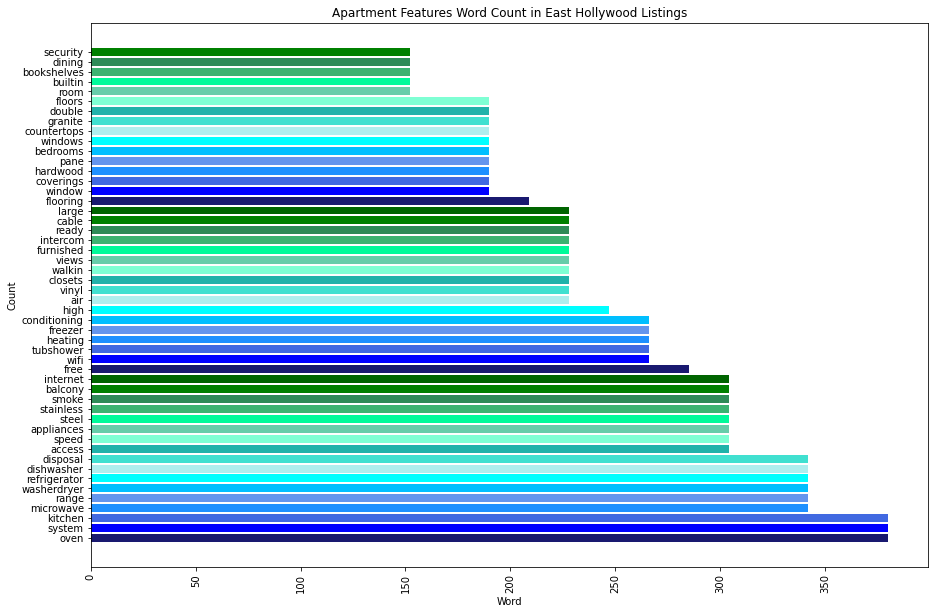

In [289]:
eho_aptfea_ = eho_aptfea_.reset_index()
#bar chart

plt.figure(figsize=(15,10))
plt.barh(eho_aptfea_.head(50)['word'], eho_aptfea_.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Apartment Features Word Count in East Hollywood Listings")
plt.show() 


Kitchen, system, and oven are most frequently cited apartment features, and then microwave, washer dreyer, fridge, dishwasher, disposal. 

#### Boyle Heights - Apartment Features

In [292]:
print("Apartment Features Frequencies - Boyle Heights")
bohe_aptfea_ = countWords_nostop(wlaf_bohe_)
bohe_aptfea_.head(20)

Apartment Features Frequencies - Boyle Heights


word_count
word                    
kitchen             5092
access              4940
floors              4484
cable               4028
ready               4028
refrigerator        4009
washerdryer         3933
internet            3762
closets             3762
speed               3762
walkin              3762
dishwasher          3724
high                3667
storage             3648
units               3648
balcony             3629
room                3420
stainless           3420
steel               3420
conditioning        3230

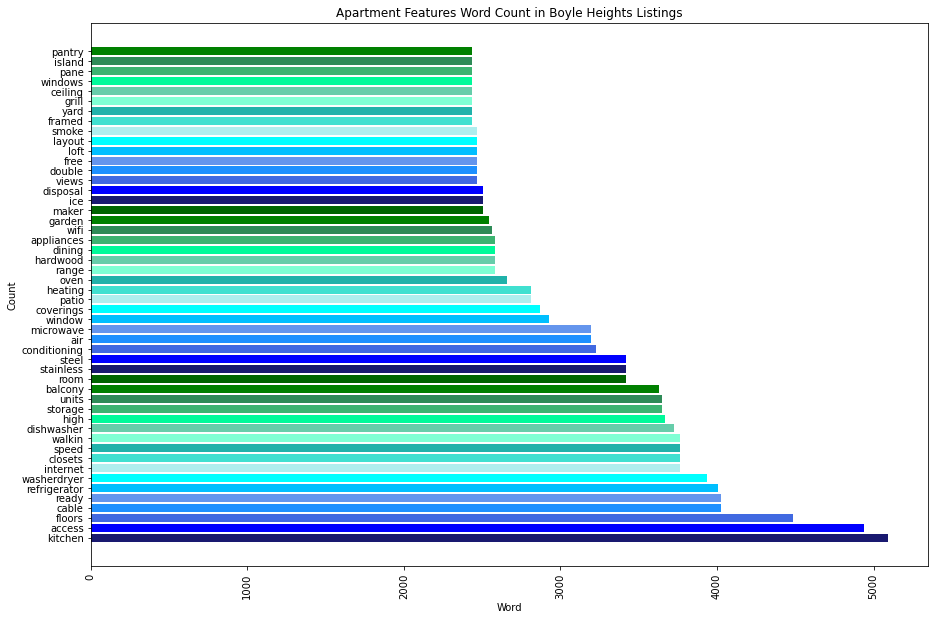

In [293]:
bohe_aptfea_ = bohe_aptfea_.reset_index()
#bar chart

plt.figure(figsize=(15,10))
plt.barh(bohe_aptfea_.head(50)['word'], bohe_aptfea_.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Apartment Features Word Count in Boyle Heights Listings")
plt.show() 

Kitchen, access, floors, cable-ready,and refrigerator were highest.

#### Koreatown - Apartment Features

In [294]:
print("Apartment Features Frequencies - Koreatown")
ktown_aptfea_ = countWords_nostop(wlaf_ktown_)
ktown_aptfea_

Apartment Features Frequencies - Koreatown


word_count
word                    
kitchen            13186
washerdryer        10127
access              9405
microwave           8892
refrigerator        8683
...                  ...
floors]               19
homes]                19
[cable                18
[[cable                1
coverings]]            1

[204 rows x 1 columns]

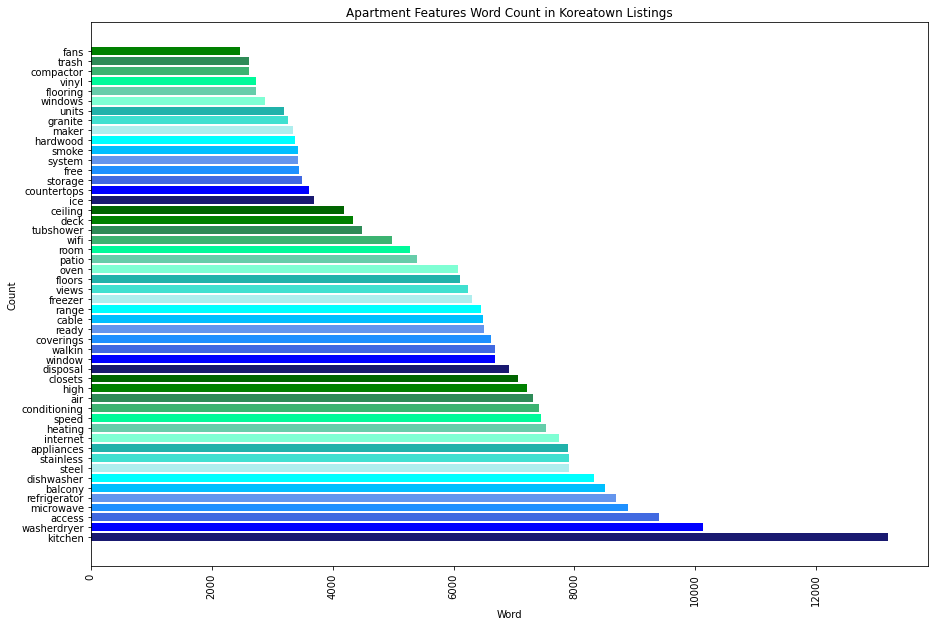

In [295]:
ktown_aptfea_ = ktown_aptfea_.reset_index()
#bar chart

plt.figure(figsize=(15,10))
plt.barh(ktown_aptfea_.head(50)['word'], ktown_aptfea_.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Apartment Features Word Count in Koreatown Listings")
plt.show() 


#### Highland Park - Apartment Features 

In [297]:
print("Apartment Features Frequencies - Highland Park")
hipa_aptfea_ = countWords_nostop(wlaf_hipa_)
hipa_aptfea_.head(10)

Apartment Features Frequencies - Highland Park


word_count
word                    
conditioning         851
stainless            832
air                  832
steel                832
dishwasher           832
internet             798
speed                798
access               760
appliances           756
disposal             718

For apartment features, **"high speed internet access"** and **"air conditioning"** were across the board the highest frequency amenities.

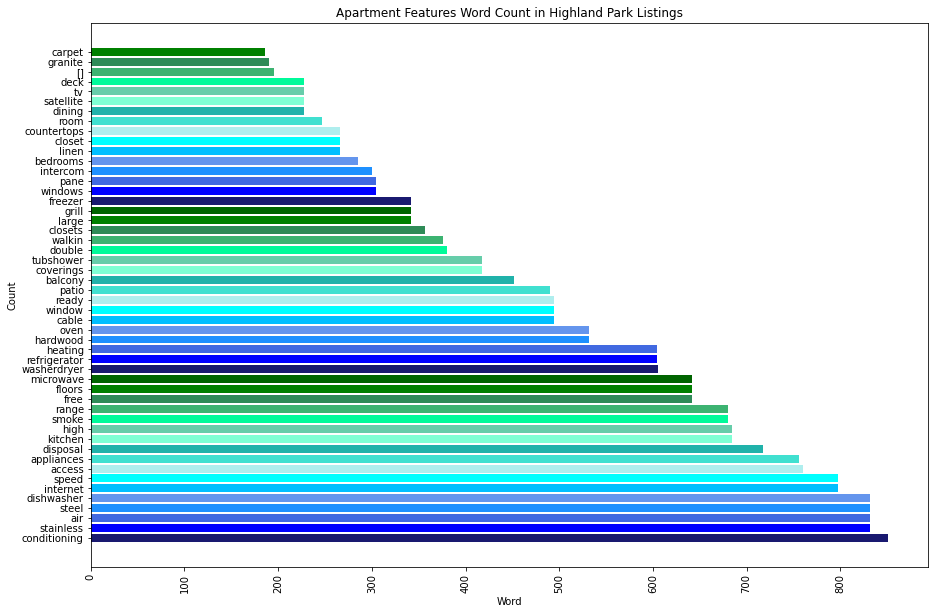

In [298]:
hipa_aptfea_ = hipa_aptfea_.reset_index()
#bar chart

plt.figure(figsize=(15,10))
plt.barh(hipa_aptfea_.head(50)['word'], hipa_aptfea_.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Apartment Features Word Count in Highland Park Listings")
plt.show() 


### Community Amenities 

#### East Hollywood - Community Amenities 

In [301]:
print("Community Amenities Frequencies - East Hollywood")
eho_comm = countWords_nostop(wlca_eho)
eho_comm.head(10)

Community Amenities Frequencies - East Hollywood


word_count
word                  
[                  327
]                  327
access             269
laundry            229
furnished          209
wifi               209
facilities         191
service            191
center             190
controlled         173

In [300]:
print("Community Amenities Frequencies - East Hollywood")
eho_comm_ = countWords_nostop(wlca_eho_)
eho_comm_.head(10)

Community Amenities Frequencies - East Hollywood


word_count
word                      
access                 114
wifi                    95
[                       94
]                       94
controlled              76
system                  76
services                57
gated                   57
transportation          57
public                  57

**"Laundry"**, **"furnished"** units and **"controlled access"** seems to be key community amenities advertised in East Hollywood, if we don't exclude 1000m+ properties. If we do exclude those, then **"wifi access"**, security systems and control, and **"public transportation"**. 

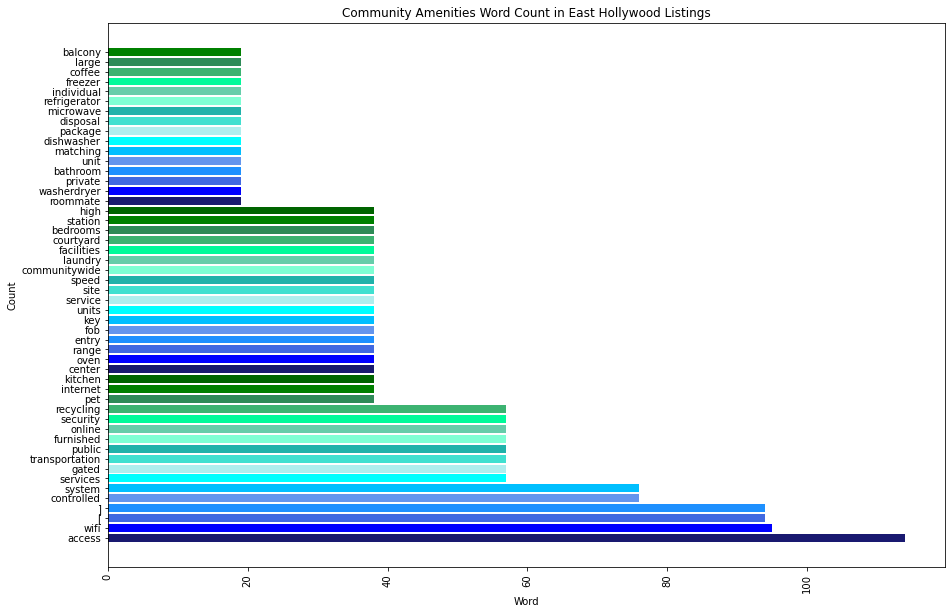

In [302]:
eho_comm_ = eho_comm_.reset_index()
#bar chart

plt.figure(figsize=(15,10))
plt.barh(eho_comm_.head(50)['word'], eho_comm_.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Community Amenities Word Count in East Hollywood Listings")
plt.show() 


#### Boyle Heights - Communtiy Amenities 

In [305]:
print("Community Amenities Frequencies - Boyle Heights")
bohe_comm_ = countWords_nostop(wlca_bohe_)
bohe_comm_.head(10)

Community Amenities Frequencies - Boyle Heights


word_count
word                    
]                    426
[                    426
washerdryer          330
air                  272
conditioning         272
refrigerator         269
unit                 268
dishwasher           253
pool                 194
facilities           186

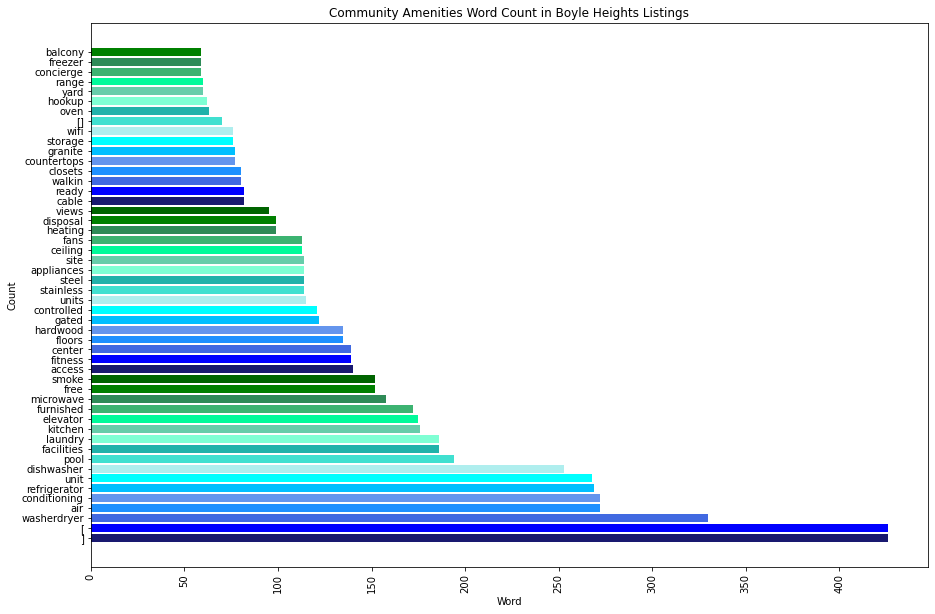

In [304]:
bohe_comm_ = bohe_comm_.reset_index()
#bar chart

plt.figure(figsize=(15,10))
plt.barh(bohe_comm_.head(50)['word'], bohe_comm_.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Community Amenities Word Count in Boyle Heights Listings")
plt.show() 


...whereas in Boyle Heights, appliances such as AC, washer dryers, dishwashers are most highlighted.

#### Koreatown - Community Amenities 

In [306]:
print("Community Amenities Frequencies - Koreatown")
ktown_comm_ = countWords_nostop(wlca_ktown_)
ktown_comm_.head(10)

Community Amenities Frequencies - Koreatown


word_count
word                 
center            437
pool              419
[                 374
]                 373
clubhouse         323
site              323
fitness           304
elevator          250
access            247
lounge            228

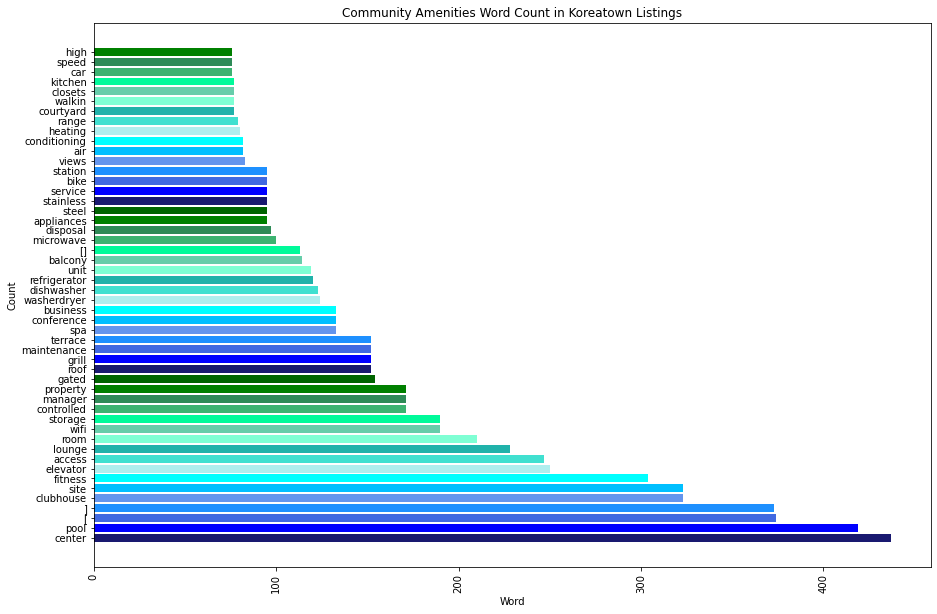

In [307]:
ktown_comm_ = ktown_comm_.reset_index()
#bar chart

plt.figure(figsize=(15,10))
plt.barh(ktown_comm_.head(50)['word'], ktown_comm_.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Community Amenities Word Count in Koreatown Listings")
plt.show() 


In Ktown, community amenities like **"pool"**, **"clubhouse"**, **"fitness center"** seem to target the young professional class.

#### Highland Park - Community Amenities

In [308]:
print("Community Amenities Frequencies - Highland Park")
hipa_comm_ = countWords_nostop(wlca_hipa_)
hipa_comm_.head(10)

Community Amenities Frequencies - Highland Park


word_count
word                    
[                    408
]                    408
air                  271
conditioning         271
gated                247
access               237
laundry              236
facilities           236
site                 209
disposal             189

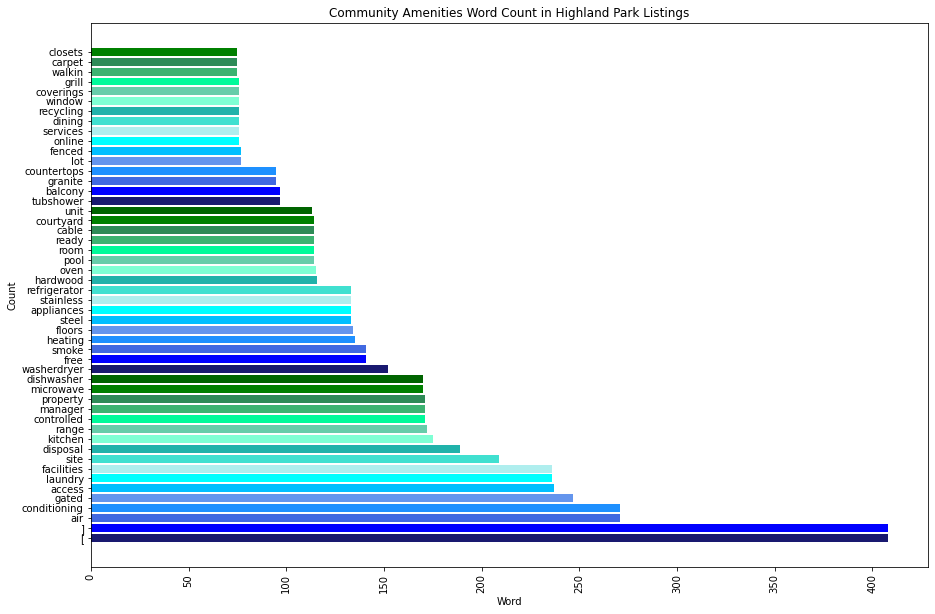

In [309]:
hipa_comm_ = hipa_comm_.reset_index()
#bar chart

plt.figure(figsize=(15,10))
plt.barh(hipa_comm_.head(50)['word'], hipa_comm_.head(50)['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")

plt.xticks(rotation=90) 

plt.title("Community Amenities Word Count in Highland Park Listings")
plt.show() 


Highland Park loves its **"AC"**,   **"gated access"** and **"laundry"**. 

Why are these amenities grouped in a staircase form? 

## NEXT: Gentrification Code Word Analysis & Mapping 

In the next notebook, I will introduce the hand-selected words that we determined were code for neighborhood change/gentrification. We ran the word counts on these words' frequencies in the Descriptions of each neighborhood's listings. I then calculated the proportion of certain words and mapped the listings color-coded by whether they included certain groups of words. 